### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 8
### Due: Saturday, Apr 6th at 11.59pm CT
---

## Only one problem this week


1. Use the following code snippet to read in SDSS galaxy color data.

#### from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()


`data = np.load('../hw_data/hw8_data_1.npy')`

This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.


3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.


4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*


5. Repeat (4) for Quadratic Discriminant Analysis. 


6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.


7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 


8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 


9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 


10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. 

# SOLUTIONS

## Problem 1

1. Use the following code snippet to read in SDSS galaxy color data.

data = np.load('../hw_data/hw8_data_1.npy')`

This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?


In [21]:
#from astroML.datasets import fetch_sdss_galaxy_colors
#data = fetch_sdss_galaxy_colors()

In [22]:
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Load the dataset 
data = np.load('/Users/jarretsm/repos/astr_8070_s24/coursework/homeworks/hw_data/hw8_data_1.npy') 

print, data.shape

(<function print>, (50000,))

In [23]:
# Print all the column names
column_names = data.dtype.names

# Create arrays for colors
u_g = data['u'] - data['g']
g_r = data['g'] - data['r']
r_i = data['r'] - data['i']
i_z = data['i'] - data['z']

# Create arrays for redshift and spec class
redshift = data['redshift']
specClass = data['specClass']

# Find number of galaxies and quasars
num_galaxies = np.count_nonzero(data['specClass'] == 'GALAXY')
num_quasars = np.count_nonzero(data['specClass'] == 'QSO')


print("Column names:", column_names)
print("Number of regular galaxies:", num_galaxies)
print("Number of quasars:", num_quasars)


Column names: ('u', 'g', 'r', 'i', 'z', 'specClass', 'redshift', 'redshift_err')
Number of regular galaxies: 42808
Number of quasars: 7192


## Problem 2

2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.

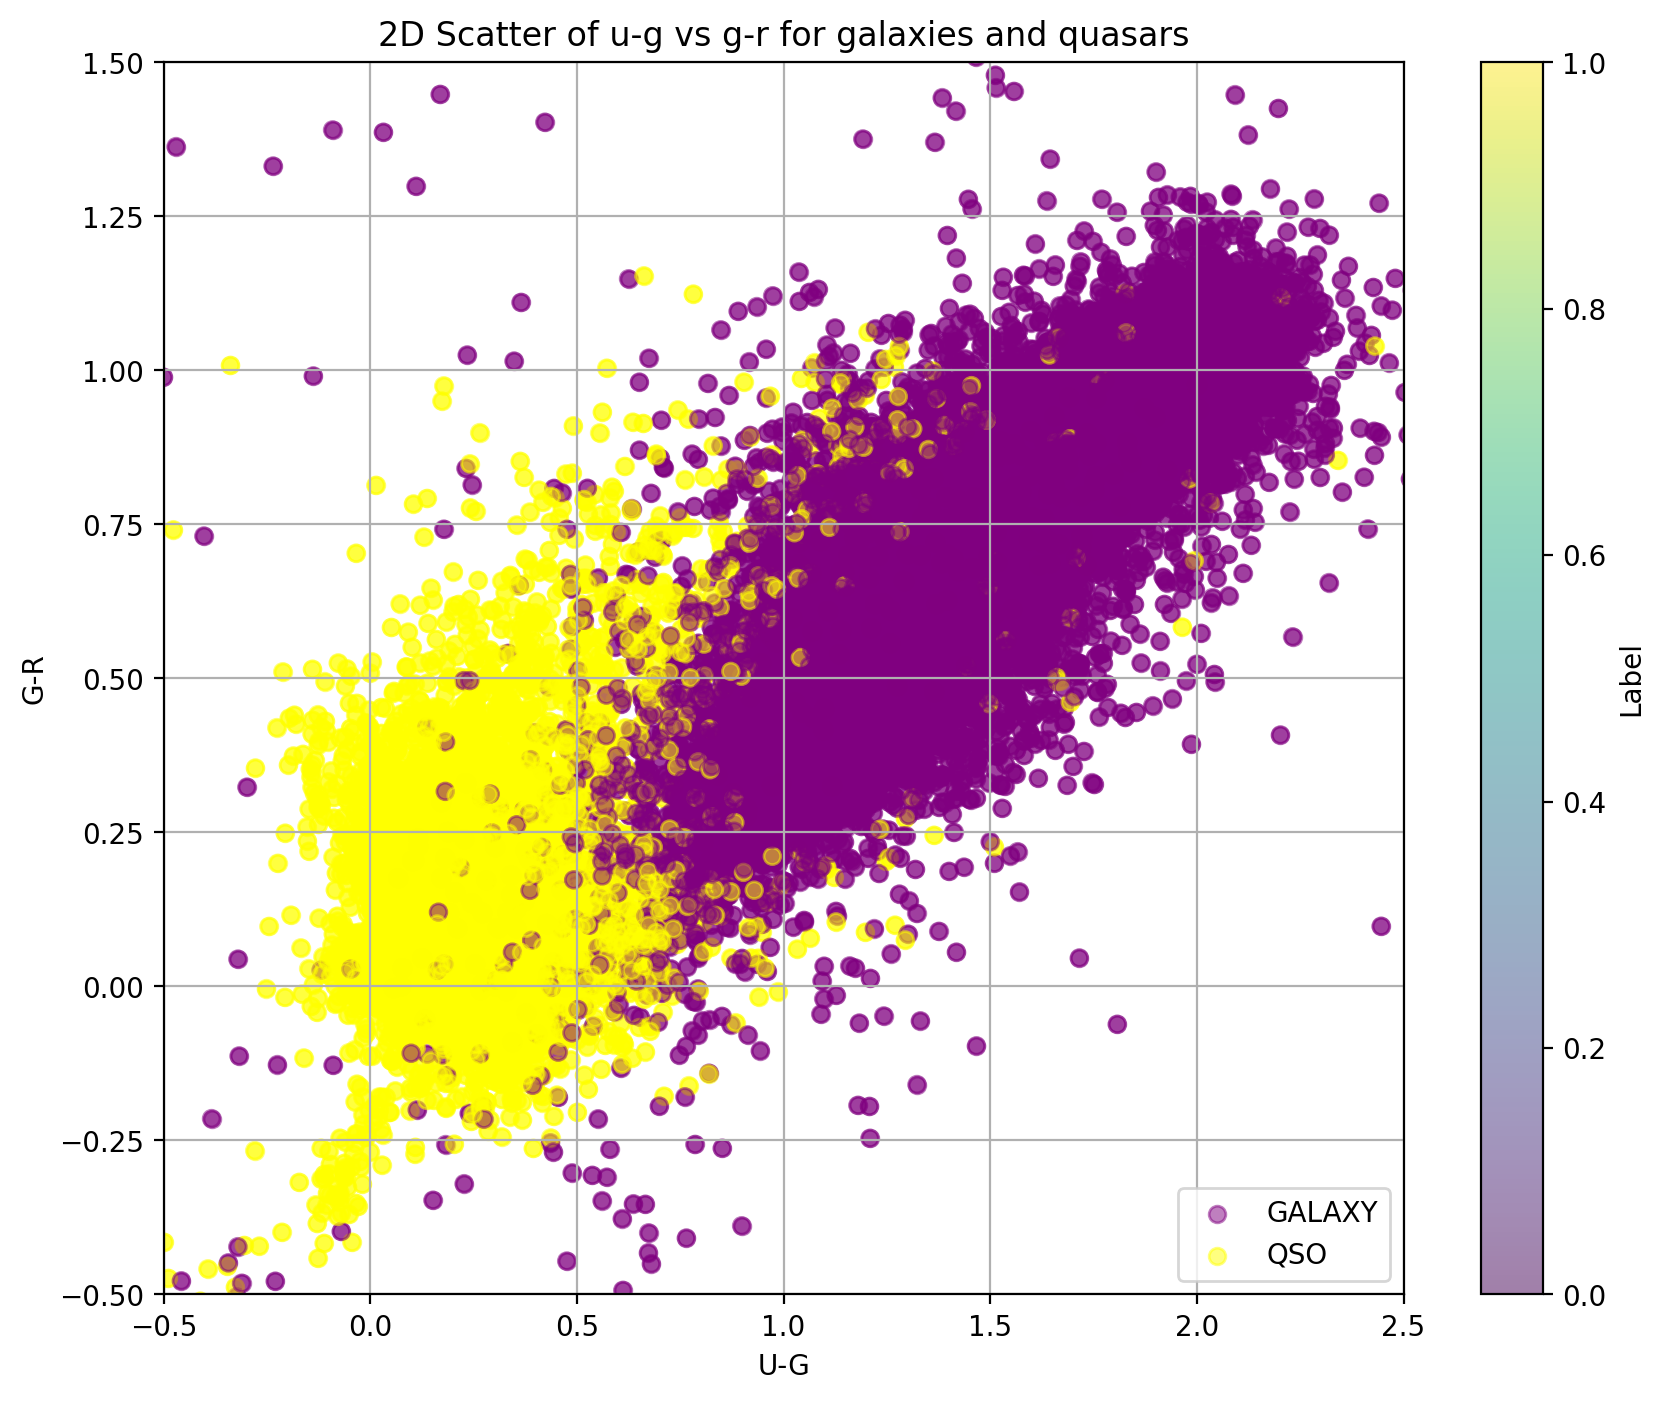

In [24]:
# Plot the data
color_map = {'GALAXY': 'purple', 'QSO': 'yellow'}
colors = np.array([color_map[i] for i in data['specClass']])


labels = np.unique(data['specClass'])

plt.figure(figsize=(10, 8))

# Plot Galaies and QSOs with color label
for category in labels:
    ix = np.where(data['specClass'] == category)
    plt.scatter(u_g[ix], g_r[ix], c=color_map[category], label=category, alpha=0.5)

scatter = plt.scatter(u_g, g_r, c=colors, alpha=0.5)
plt.title('2D Scatter of u-g vs g-r for galaxies and quasars')
plt.xlabel('U-G')
plt.ylabel('G-R')
plt.xlim(-0.5, 2.5)
plt.ylim(-0.5, 1.5)
plt.colorbar(scatter, label='Label')
plt.legend()
plt.grid(True)
plt.show()


## Problem 3

3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.


In [25]:
from sklearn.model_selection import train_test_split

# Stack colors and redshift into matrix
X = np.column_stack((u_g, g_r, r_i, i_z, redshift))

# Create target label 
y = np.array([0 if cls == 'GALAXY' else 1 for cls in data['specClass']])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)    #0.2 for 20%

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")



X_train shape: (40000, 5)
y_train shape: (40000,)


## Problem 4

4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*


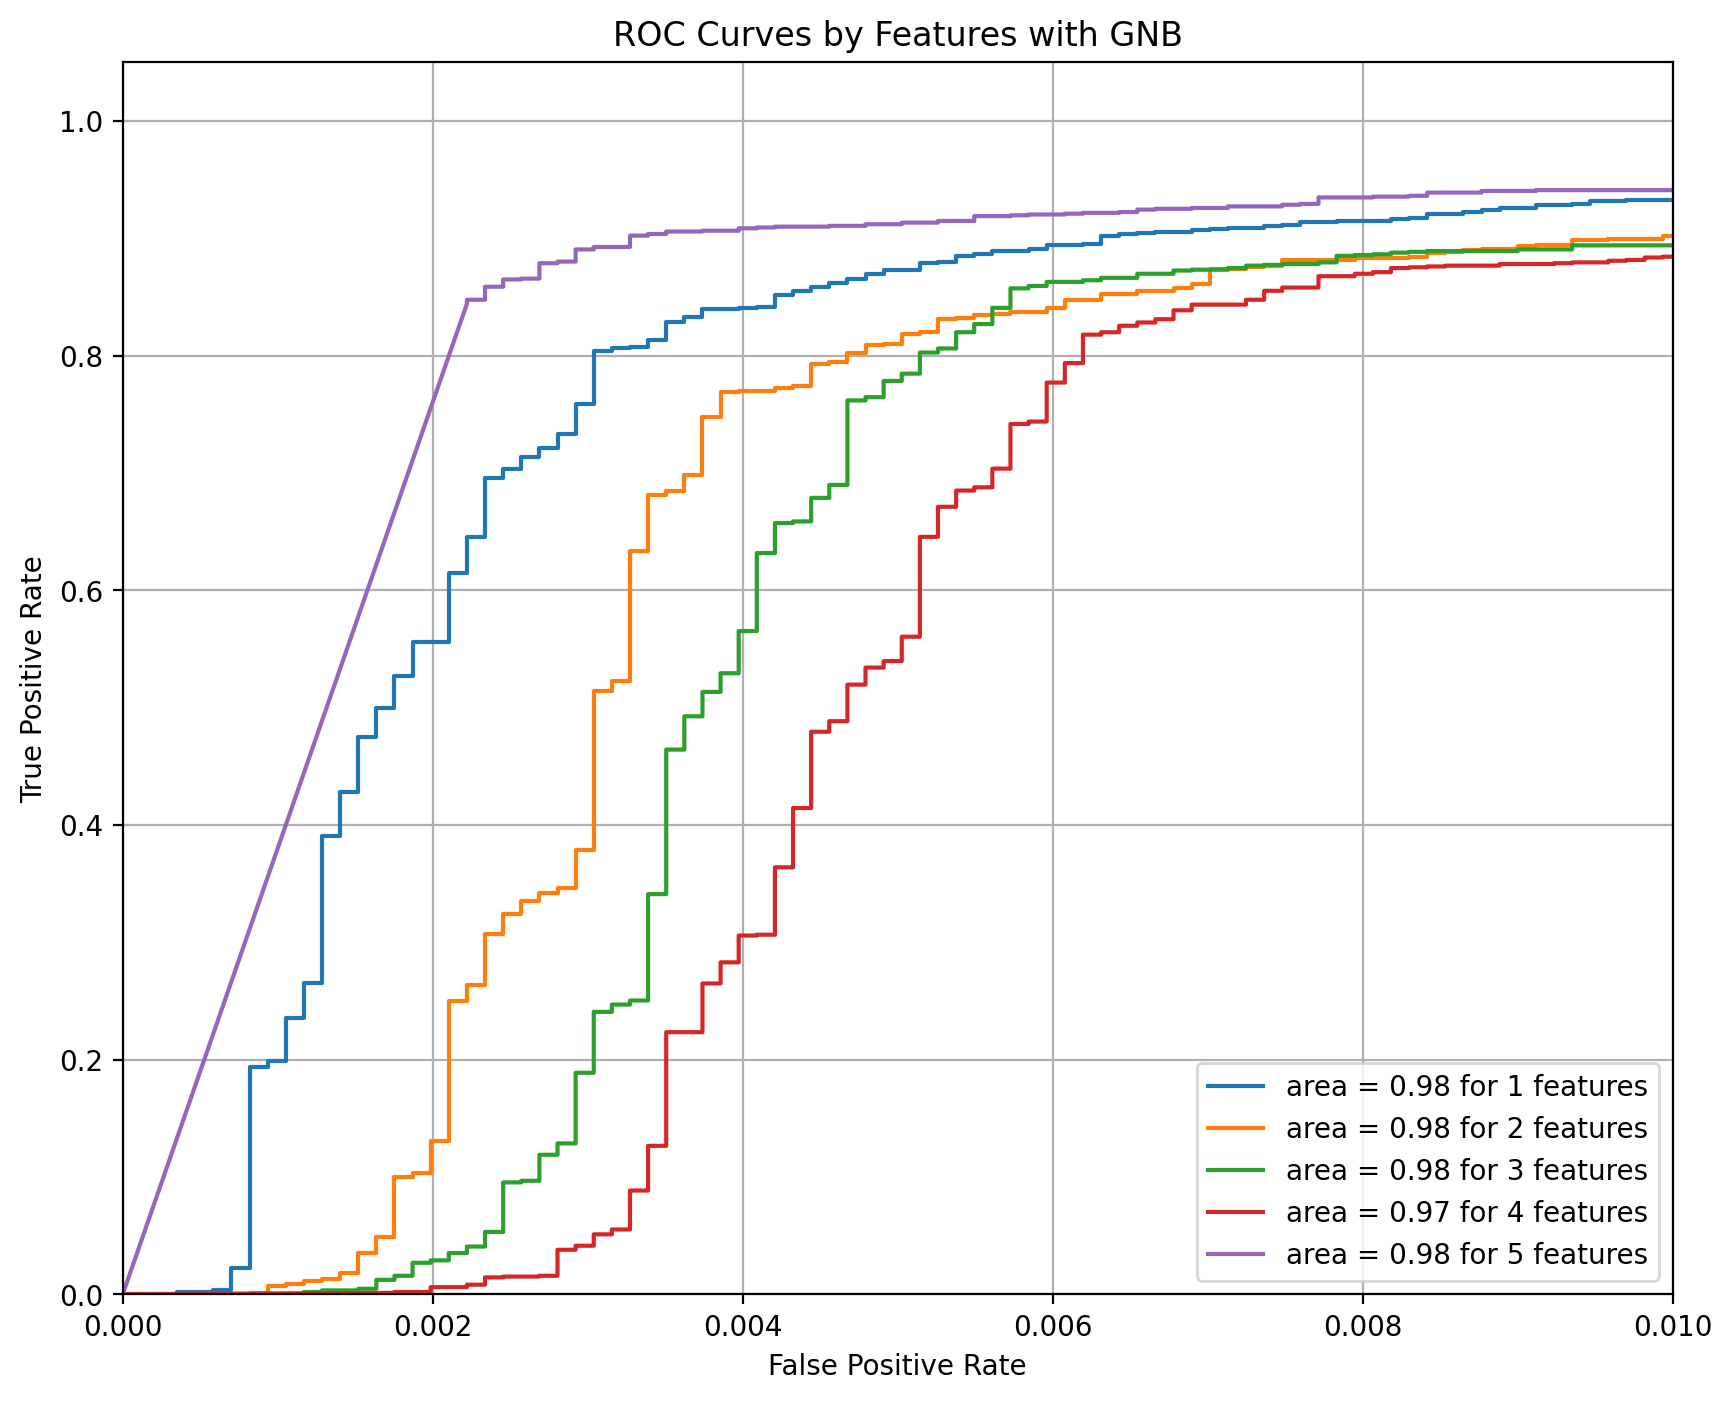

In [26]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))
for i in range(1, X_train.shape[1] + 1):
    # Fit GNB Model
    gnb = GaussianNB()
    gnb.fit(X_train[:, :i], y_train)
    
    # Predict for test
    y_score = gnb.predict_proba(X_test[:, :i])[:, 1]
    
    # Get ROC curve 
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'area = {roc_auc:.2f} for {i} features')

plt.xlim(0, 0.01)
plt.ylim(0.0, 1.05)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Features with GNB')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### The feature that makes the classification easy will be the one with the largest area under the curve because it means it is performing better than the others. There are actually several ROC curves for the different number of features that perform very well given that feature 1,2,3,and 5 have the same area. However it is best to choose the most simple model which would be the one that uses the lowest amount of features. So they best choice is Feature 1, despite the other features doing well. 

SRT: Excellent, and good commentary.

## Problem 5

5. Repeat (4) for Quadratic Discriminant Analysis. 



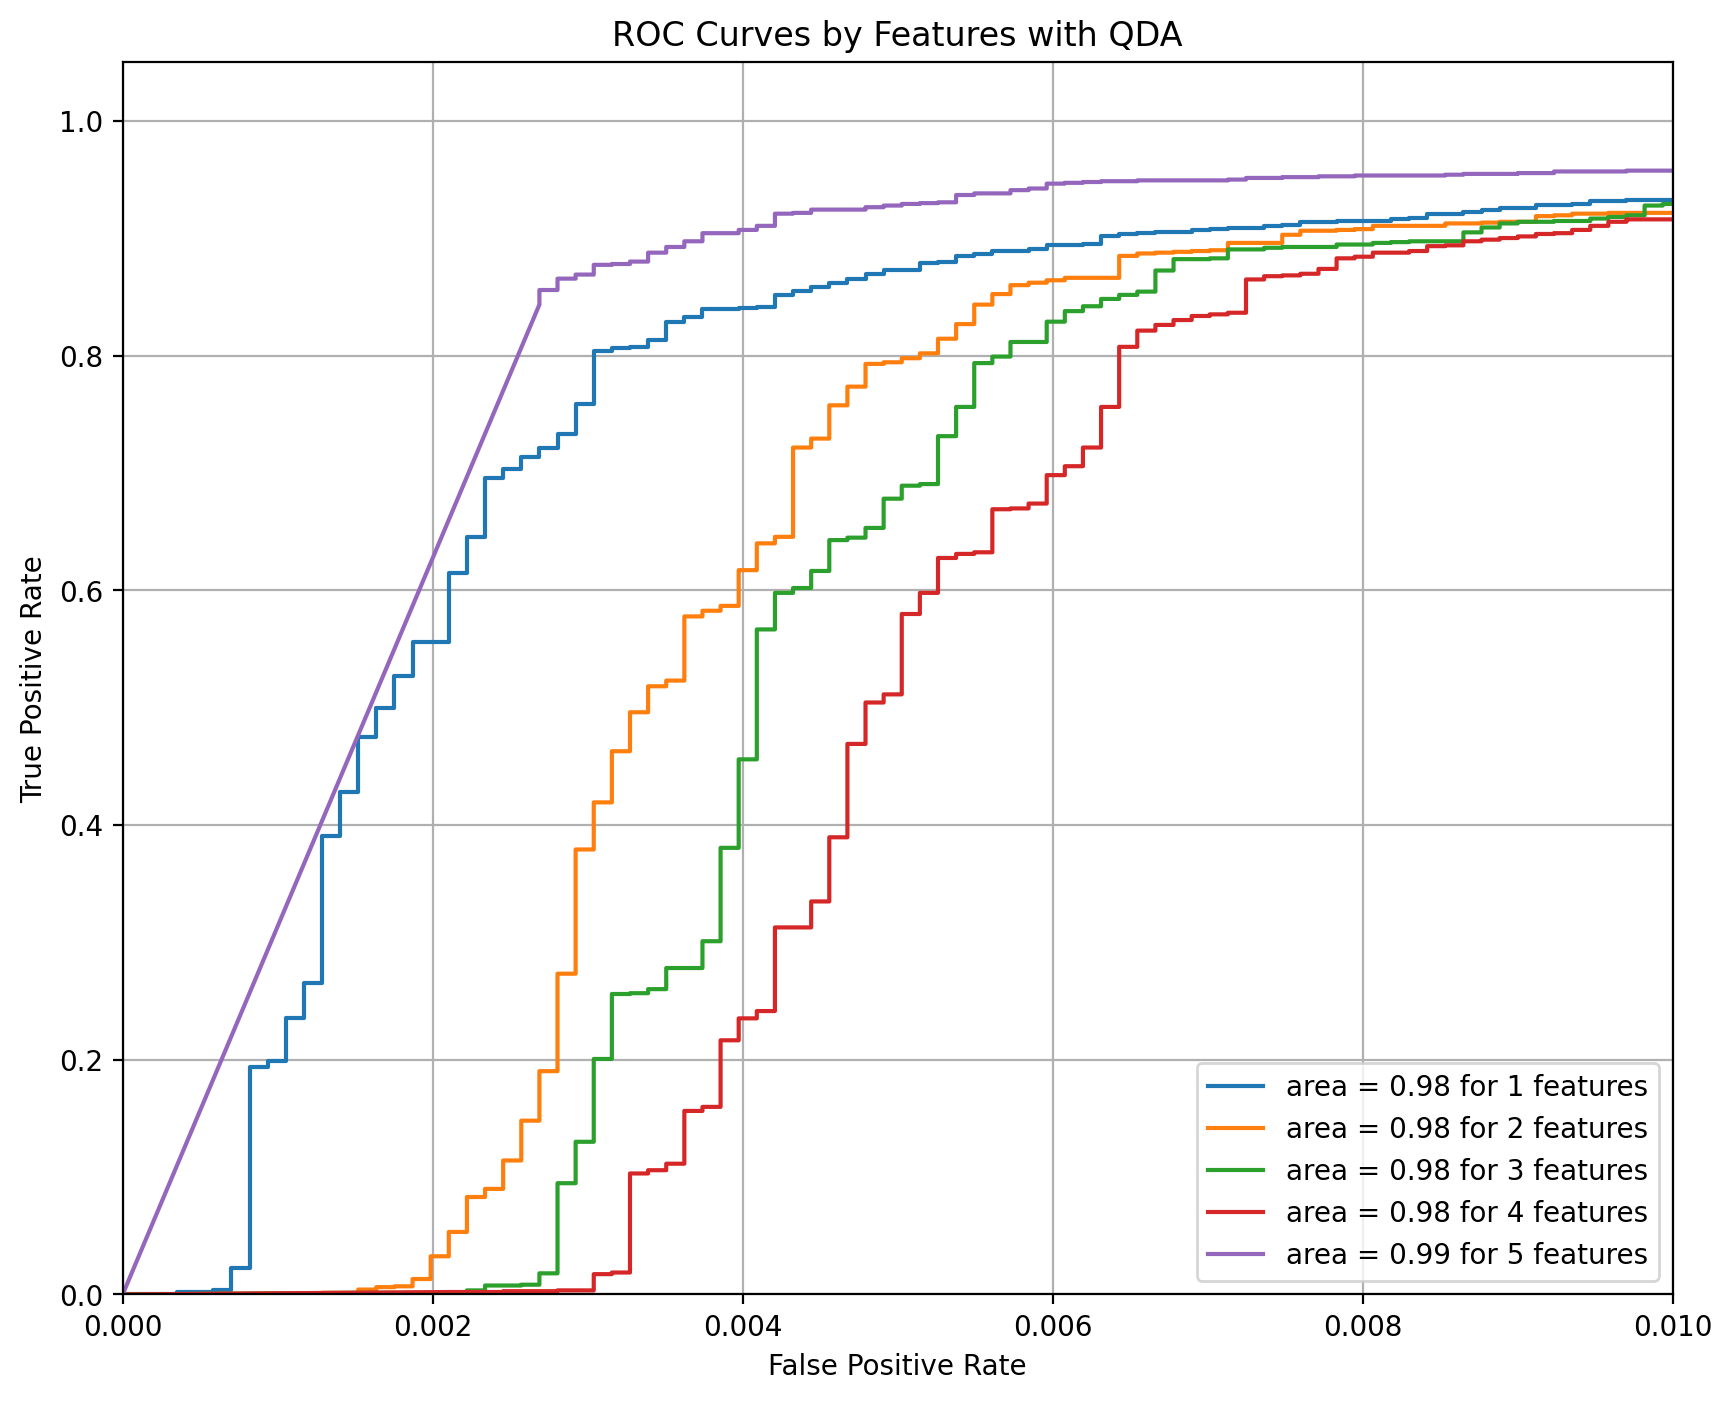

In [27]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

plt.figure(figsize=(10, 8))
for i in range(1, X_train.shape[1] + 1):
    # Fit QDA Model
    qda = QuadraticDiscriminantAnalysis()
    qda.fit(X_train[:, :i], y_train)
    
    # Predict for test
    y_score = qda.predict_proba(X_test[:, :i])[:, 1]
    
    # Get ROC curve 
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'area = {roc_auc:.2f} for {i} features')

plt.xlim(0, 0.01)
plt.ylim(0.0, 1.05)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Features with QDA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## Problem 6

6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.

In [28]:
#Constrain to just colors
X = np.column_stack((u_g, g_r, r_i, i_z))
X_train_colors = X_train[:, :4] 
X_test_colors = X_test[:, :4] 

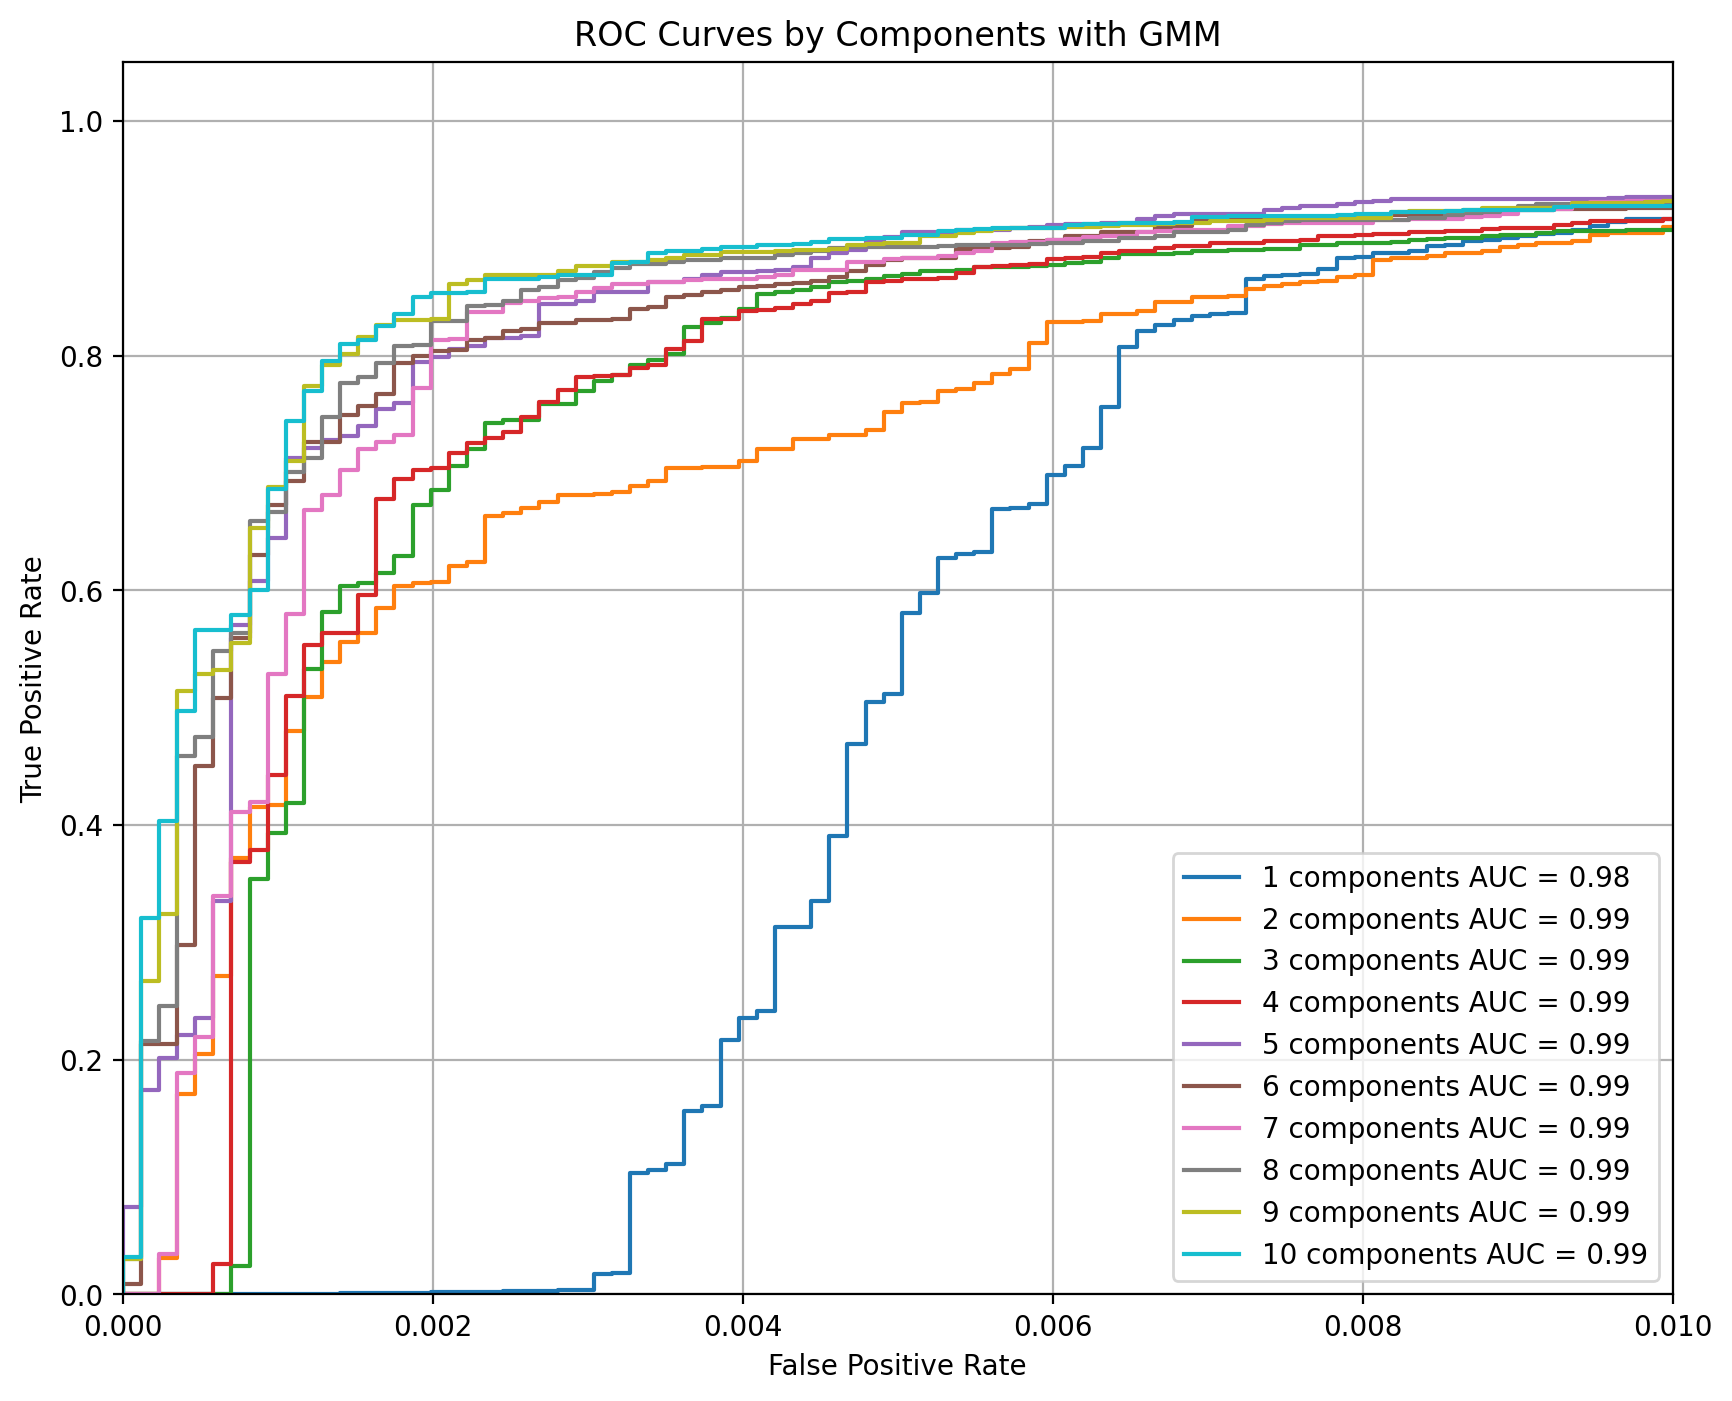

In [29]:
#Do GMM Bayes fit and ROC curves
from sklearn.mixture import GaussianMixture

plt.figure(figsize=(10, 8))
for n_components in range(1, 11):
    # Create a GMM for galaxies and QSO
    gmm0 = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
    gmm1 = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
    
    # Fit GMMs to training data
    gmm0.fit(X_train_colors[y_train == 0])
    gmm1.fit(X_train_colors[y_train == 1])
    
    # Calculate the log likelihood 
    log_likelihood_0 = gmm0.score_samples(X_test_colors)
    log_likelihood_1 = gmm1.score_samples(X_test_colors)
    
    # Get ROC Curve scoring
    scores = log_likelihood_1 - log_likelihood_0
    
    # Get ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, scores)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC
    plt.plot(fpr, tpr, label='{} components AUC = {:.2f}'.format(n_components, roc_auc))

plt.xlim([0, 0.01])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Components with GMM')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


#### The number of components that will give the best performance will again be the one with the largest area under the curve. Similar to the example using GNB to identify the nuber of features that gives the best model performance, here we have several high performing models based on differing component numbers. This includes components 2 - 10. Again, because we prefer a more simple model, the best number of components would be 2 components, in Orange. 

SRT: This was very well thought through and evaluated, Shaniya. It's technically not the correct solution, because the classifier is `GMMBayes`, which would have allowed you to classify using the same attributes as in QDA and GNB. I won't deduct points since you didn't give up!

## Problem 7

7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 

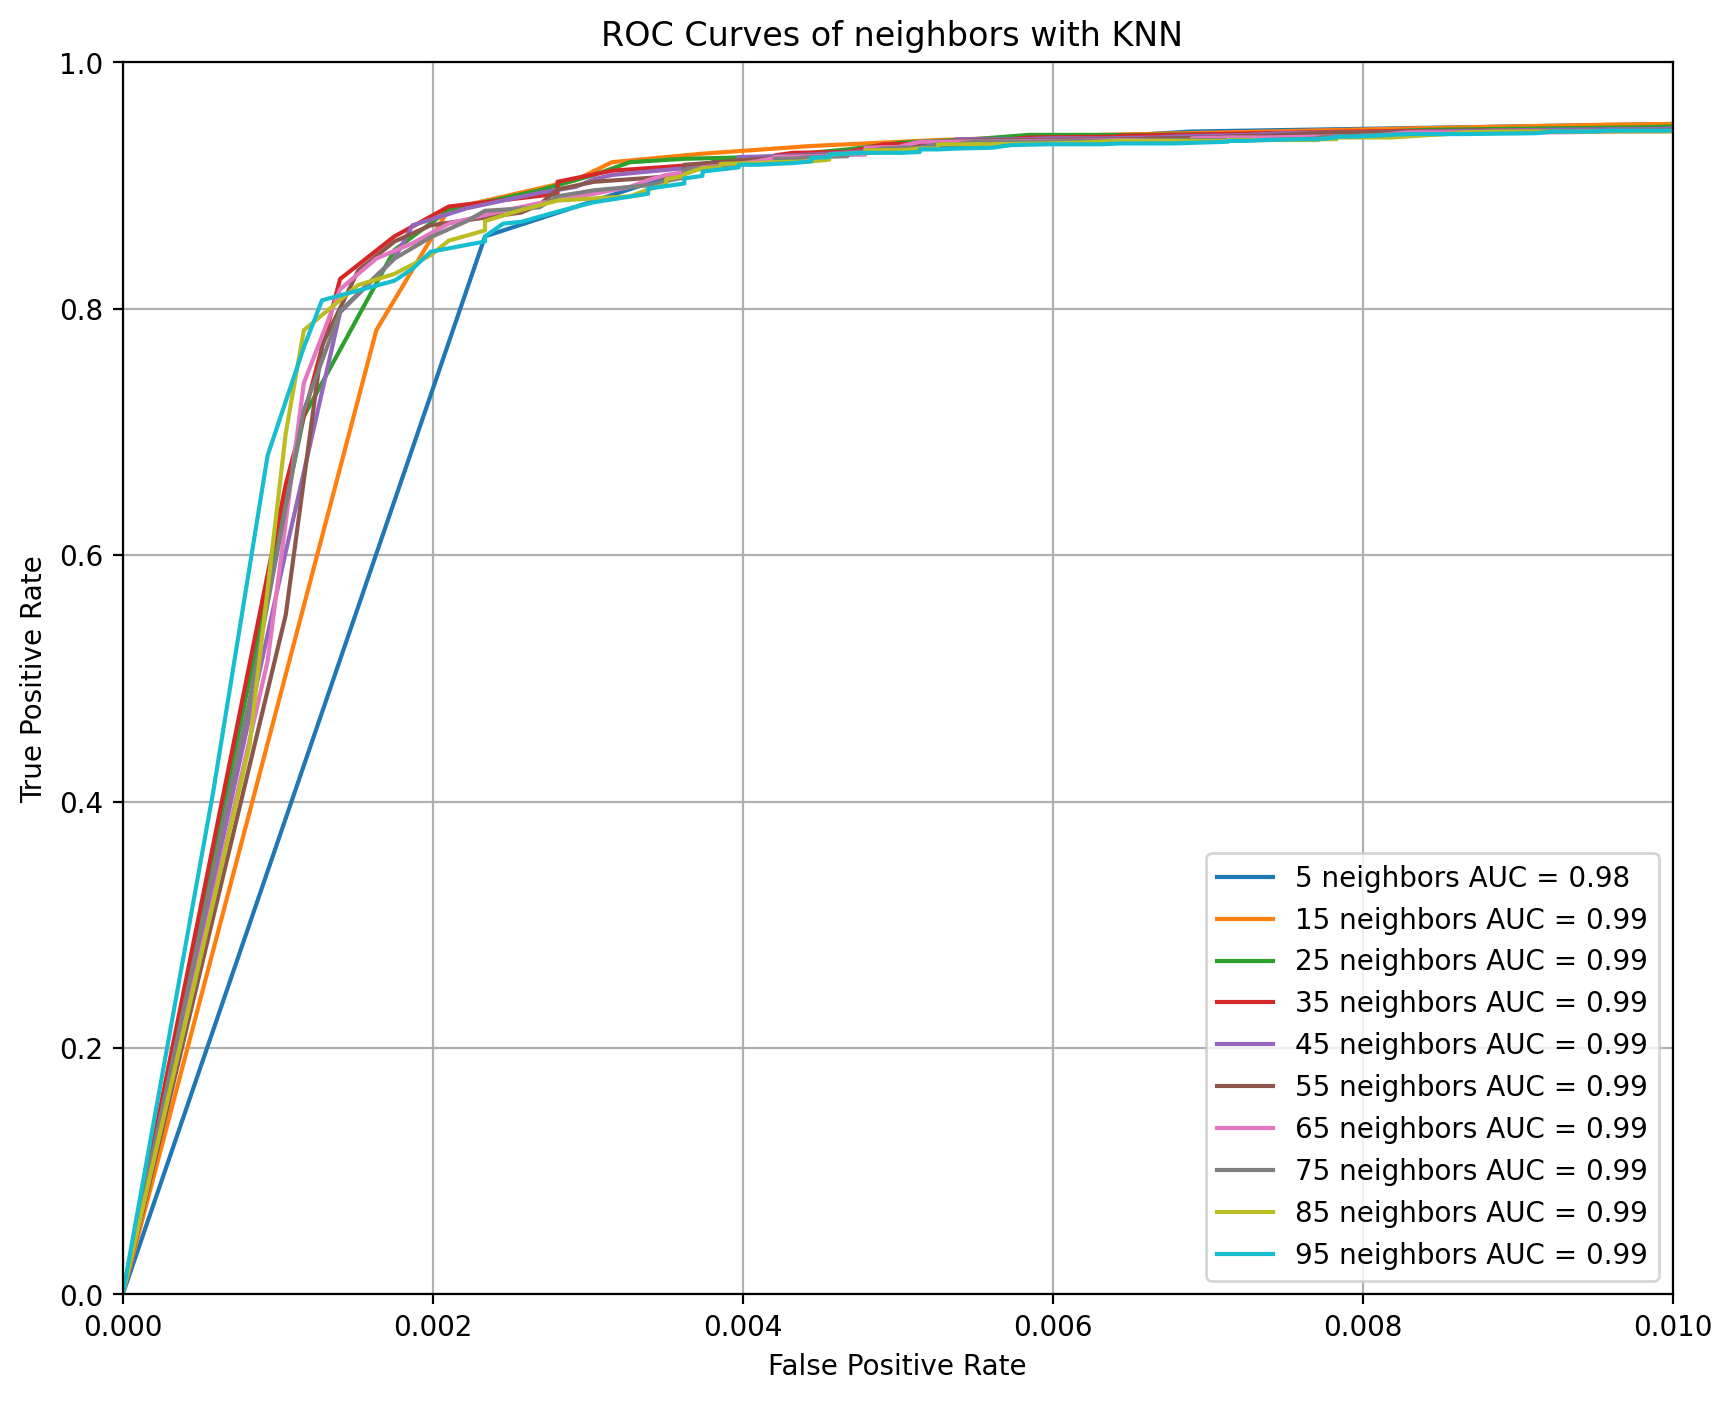

In [30]:
from sklearn.neighbors import KNeighborsClassifier

plt.figure(figsize=(10, 8))
for n_neighbors in range(5, 100, 10):
    # Create KNN
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    # Fit to data
    knn.fit(X_train_colors, y_train)
    
    # Predict scores
    y_score = knn.predict_proba(X_test_colors)[:, 1]
    
    # Get ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    # Plot
    plt.plot(fpr, tpr, label='{} neighbors AUC = {:.2f}'.format(n_neighbors, roc_auc))

plt.xlim([0, 0.01])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of neighbors with KNN ')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



#### The number of neighbors that will give the best performance will be 15 neighbors because it has the largest AUC but the lowest number of neighbors. Again, most of these numbers of neighbors still perform very high but are penalized for complexity. 

SRT: Fair deduction. You are incorporating a sense of Occam penalty.

## Problem 8

8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 

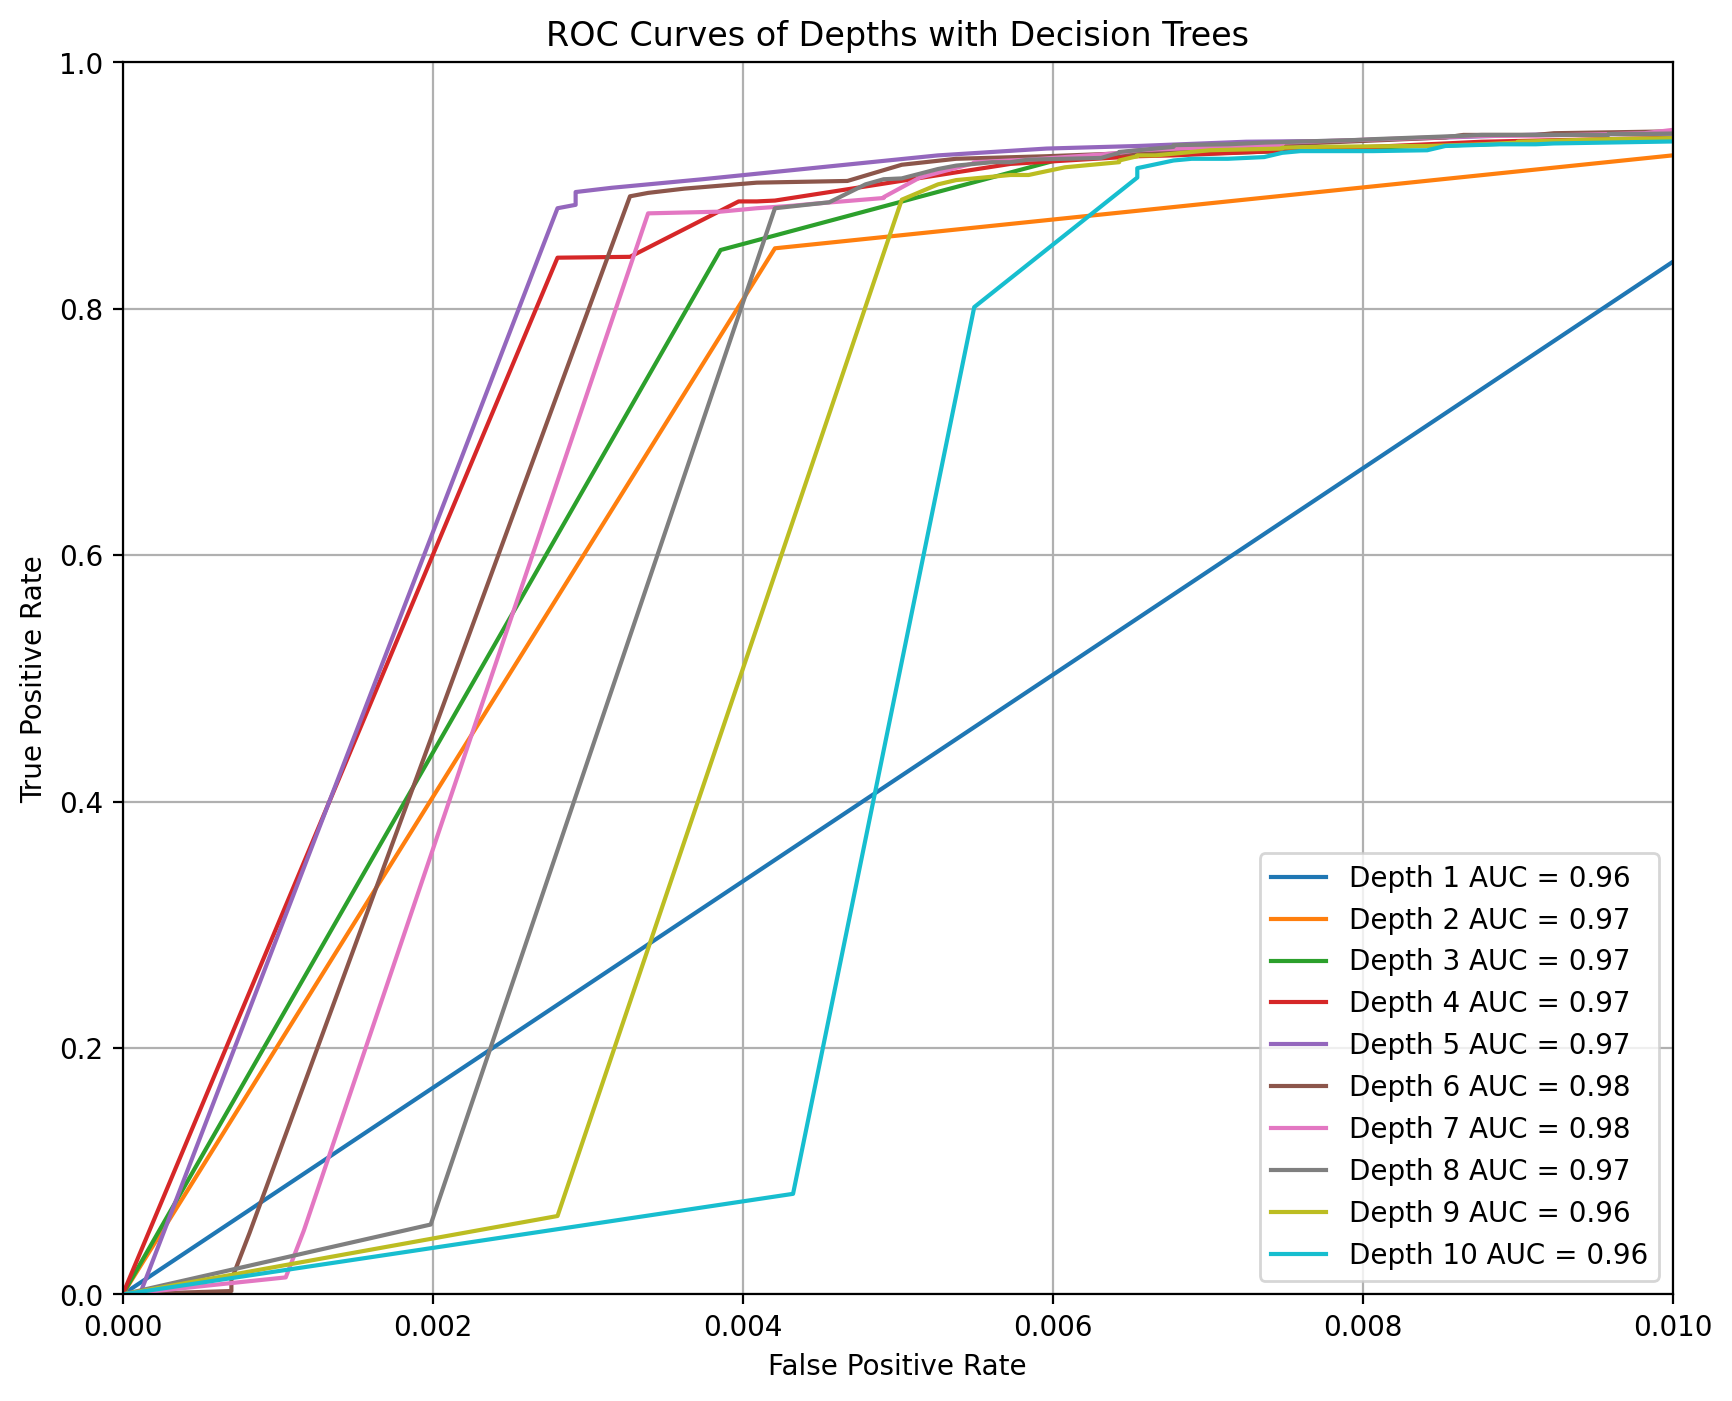

In [31]:
from sklearn.tree import DecisionTreeClassifier


plt.figure(figsize=(10, 8))
for depth in range(1, 11):
    # Create Decision Tree 
    dtree = DecisionTreeClassifier(max_depth=depth, random_state=0)
    
    # Fit to data
    dtree.fit(X_train_colors, y_train)
    
    # Predict scores
    y_score = dtree.predict_proba(X_test_colors)[:, 1]
    
    # Get ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    # Plot 
    plt.plot(fpr, tpr, label='Depth {} AUC = {:.2f}'.format(depth, roc_auc))

plt.xlim([0, 0.01])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of Depths with Decision Trees')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### The number of depths that will give the best performance will be a depth of 6 because it has the largest AUC at 0.98 and the lowest depth number for that higher AUC.

## Problem 9

9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 

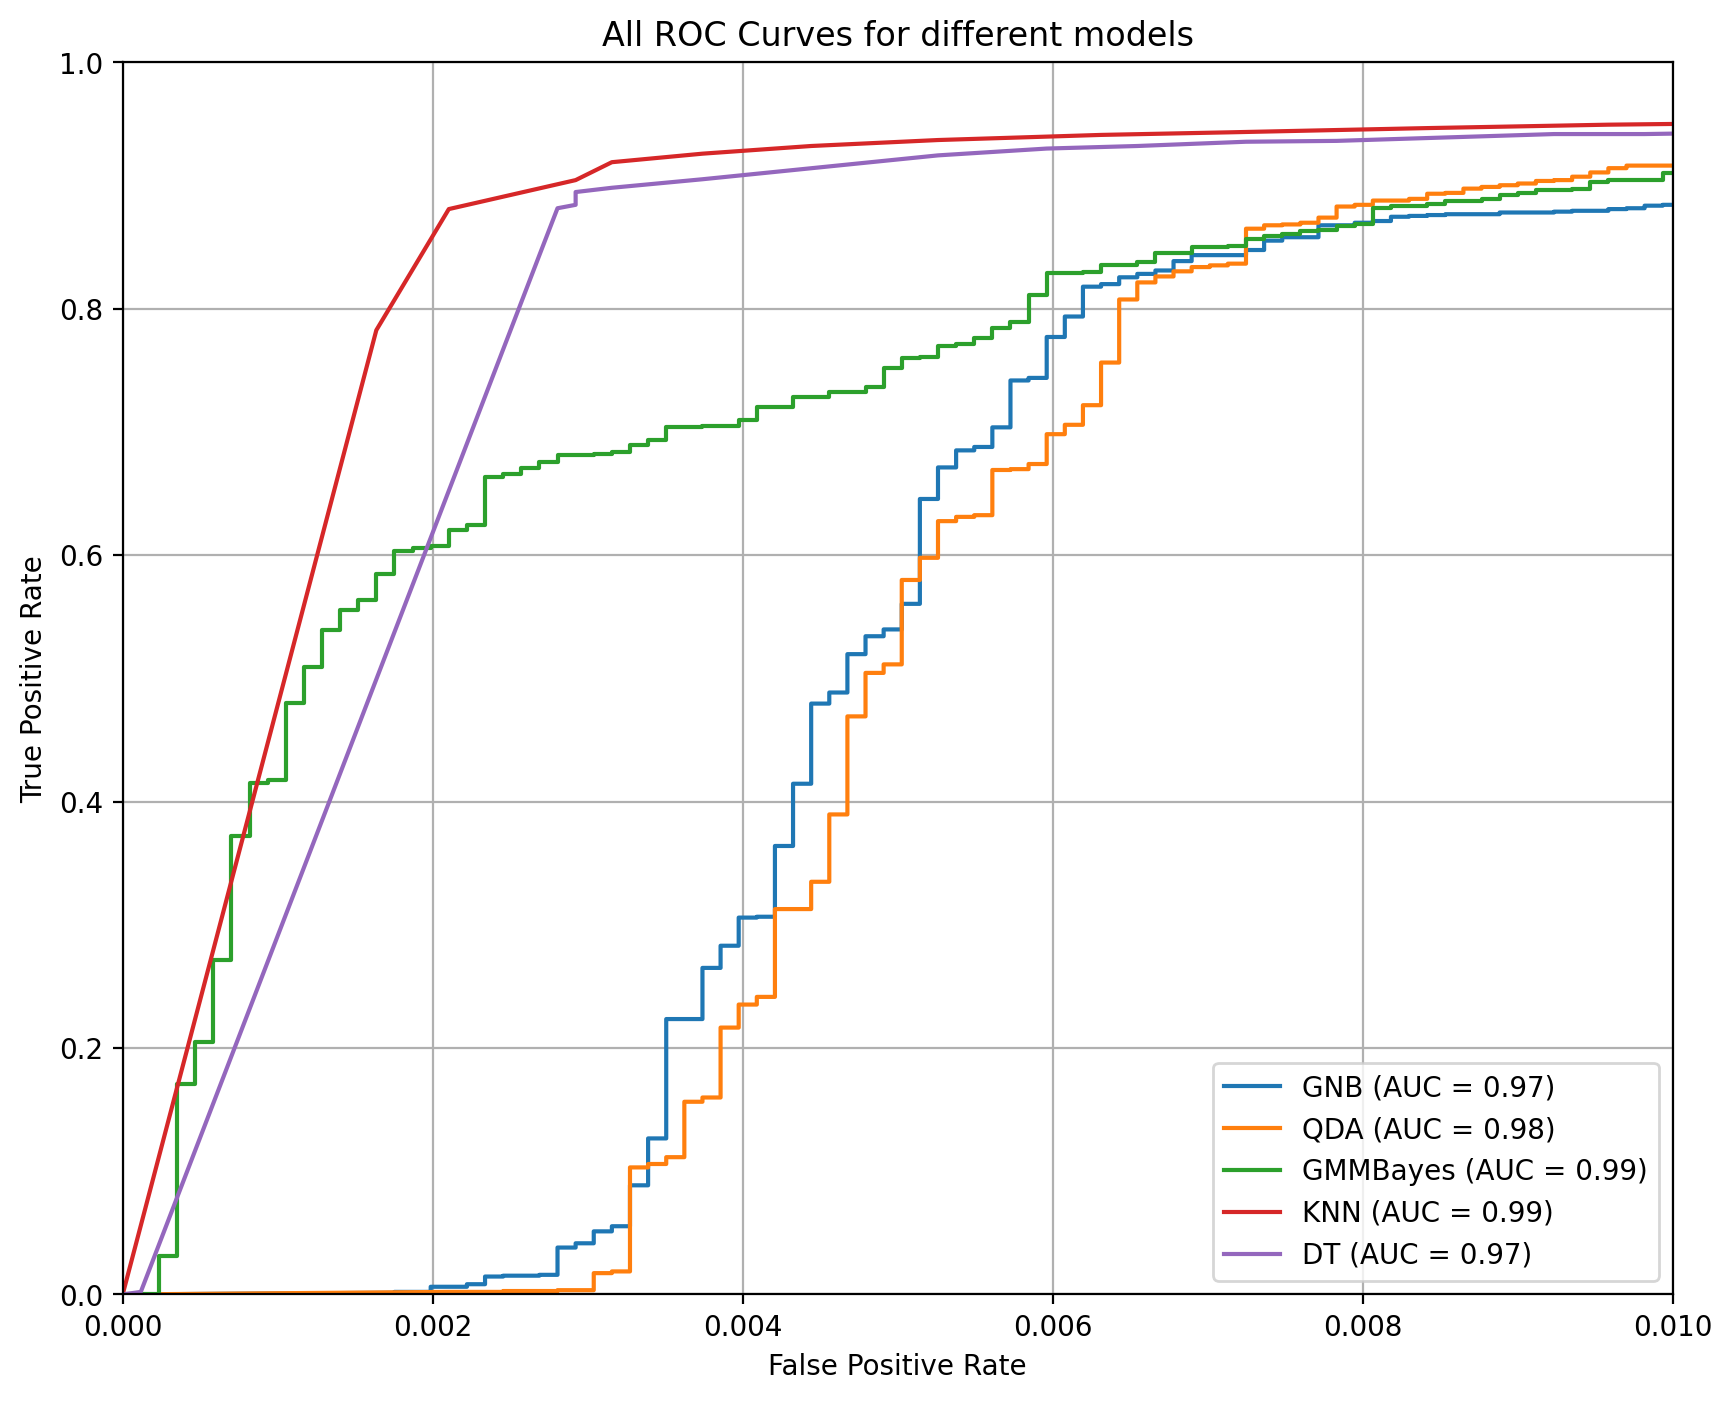

In [32]:
best_gmm = 2
best_knn = 15
best_dt = 5

# GNB Model 
gnb = GaussianNB()
gnb.fit(X_train_colors, y_train)
y_score_gnb = gnb.predict_proba(X_test_colors)[:, 1]

# QDA Model 
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_colors, y_train)
y_score_qda = qda.predict_proba(X_test_colors)[:, 1]

# GMM Model 
gmm0 = GaussianMixture(n_components=best_gmm, covariance_type='full', random_state=0)
gmm1 = GaussianMixture(n_components=best_gmm, covariance_type='full', random_state=0)
gmm0.fit(X_train_colors[y_train == 0])
gmm1.fit(X_train_colors[y_train == 1])
log_likelihood_0 = gmm0.score_samples(X_test_colors)
log_likelihood_1 = gmm1.score_samples(X_test_colors)
scores_gmm = log_likelihood_1 - log_likelihood_0

# KNN Model 
knn = KNeighborsClassifier(n_neighbors=best_knn)
knn.fit(X_train_colors, y_train)
y_score_knn = knn.predict_proba(X_test_colors)[:, 1]

# Decision Tree Model 
dtree = DecisionTreeClassifier(max_depth=best_dt, random_state=0)
dtree.fit(X_train_colors, y_train)
y_score_dt = dtree.predict_proba(X_test_colors)[:, 1]

#============== Plot all ROC curves=========================================
plt.figure(figsize=(10, 8))

# Calculate and plot ROC curve for each classifier
for clf, y_score, label in zip([gnb, qda, gmm0, knn, dtree],
                               [y_score_gnb, y_score_qda, scores_gmm, y_score_knn, y_score_dt],
                               ['GNB', 'QDA', 'GMMBayes', 'KNN', 'DT']):
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.xlim([0, 0.01])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('All ROC Curves for different models')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


#### The overall best performer is a tie between GMM Bayes and K nearest neighbor because they both have the highest AUC compared to the other models. The worst performers came from the decision tree and the Gaussian  Naive Bayes, but it does seem that each of the models performed very well. 

## Problem 10


10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. 

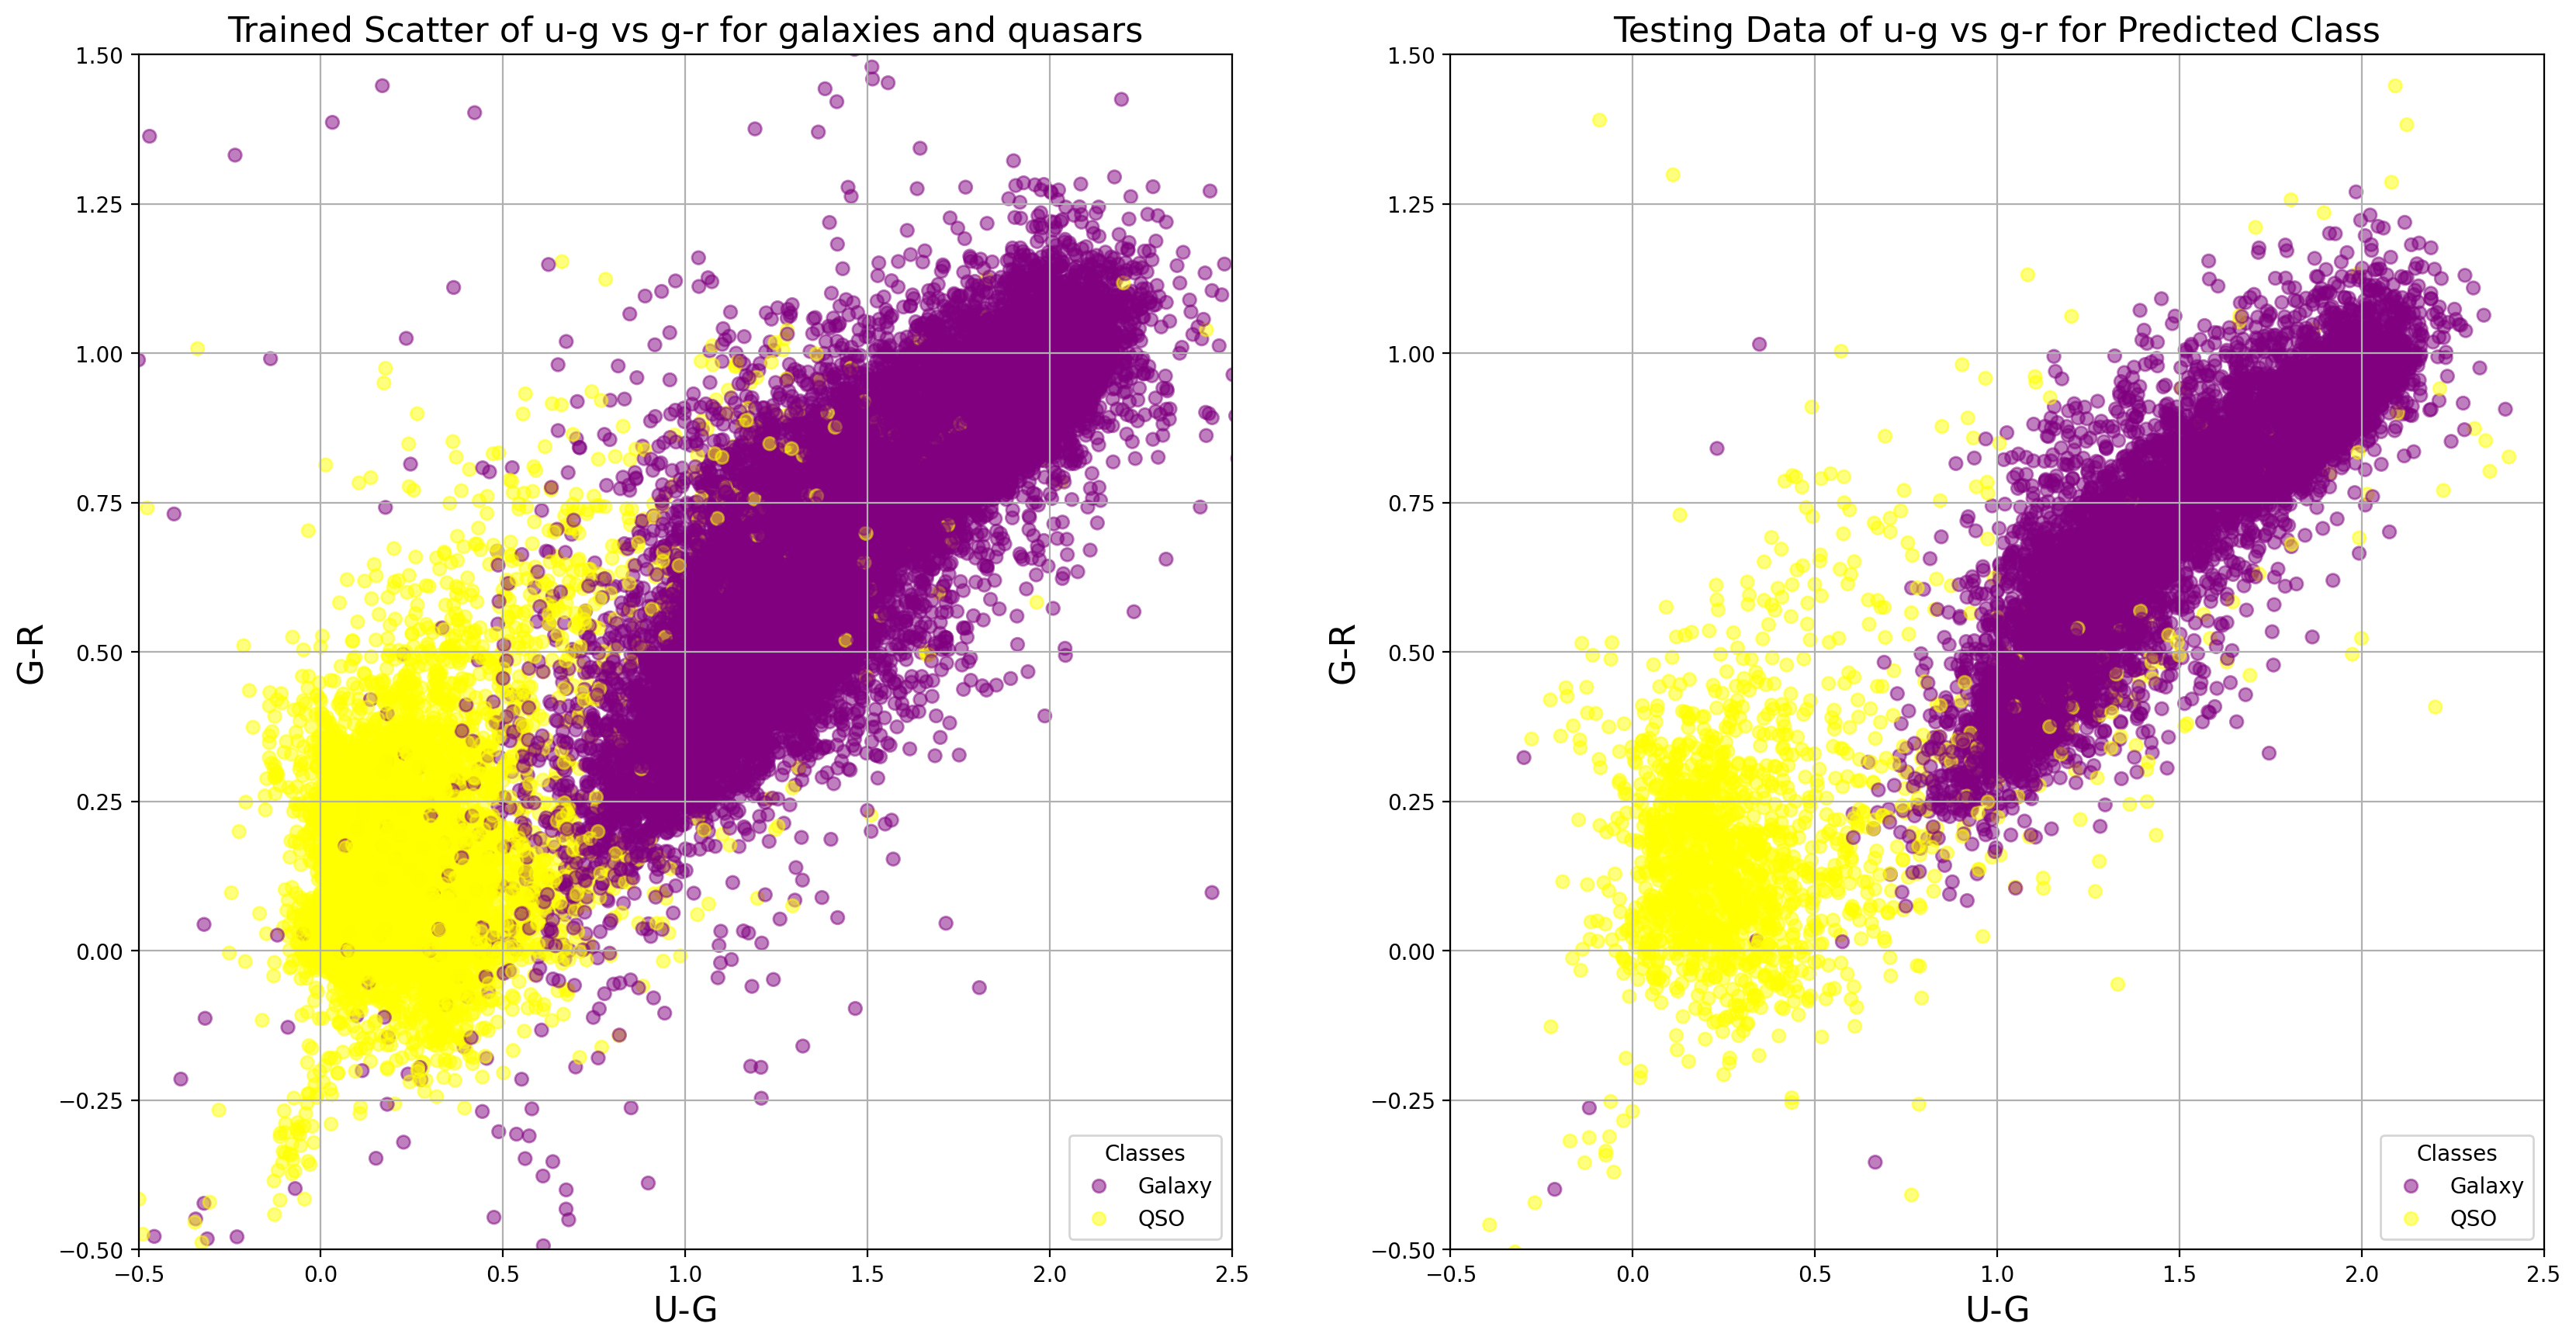

In [33]:

from matplotlib.colors import ListedColormap


# GMM Liklihoods for test data
likelihood0 = gmm0.score_samples(X_test_colors)
likelihood1 = gmm1.score_samples(X_test_colors)

# Classify based on the higher likelihood
y_pred = likelihood1 > likelihood0

plt.figure(figsize=(20, 10))
cmap = ListedColormap(['purple', 'yellow'])


# OG plot but with trained data
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_train_colors[:, 0], X_train_colors[:, 1], c=y_train, alpha=0.5, cmap=cmap)
plt.title('Trained Scatter of u-g vs g-r for galaxies and quasars', fontsize=16)
plt.xlabel('U-G', fontsize=16)
plt.ylabel('G-R', fontsize=16)
plt.legend(handles=scatter.legend_elements()[0], labels=['Galaxy', 'QSO'], title="Classes")
plt.xlim(-0.5, 2.5)
plt.ylim(-0.5, 1.5)
plt.grid(True)

# Data based on classifyer
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_test_colors[:, 0], X_test_colors[:, 1], c=y_pred.astype(int), alpha=0.5, cmap=cmap)
plt.title('Testing Data of u-g vs g-r for Predicted Class', fontsize=16)
plt.xlabel('U-G', fontsize=16)
plt.ylabel('G-R', fontsize=16)
plt.legend(handles=scatter.legend_elements()[0], labels=['Galaxy', 'QSO'], title="Classes")
plt.xlim(-0.5, 2.5)
plt.ylim(-0.5, 1.5)
plt.grid(True)

plt.show()


SRT: Great work, Shaniya.